<b><font color='red' size="10">2) Multi-Classification avec Softmax</font> </b>

<b><font color='blue' size="6">a) Préparation des données (comme précédemment)</font> </b>

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


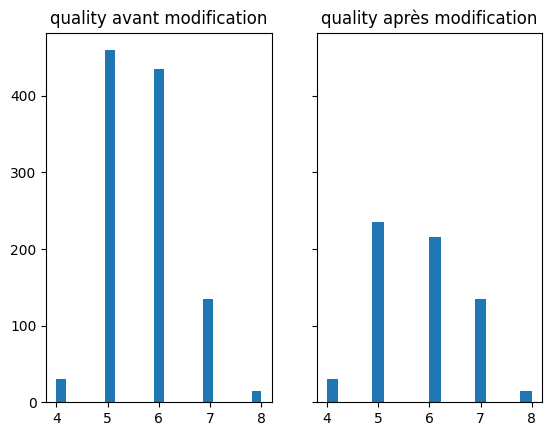

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def zscore_normalize_features(X):
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

 # normalize the original features
X_train, X_mu, X_sigma = zscore_normalize_features(X_train)
X_cv, X_mu, X_sigma = zscore_normalize_features(X_cv)
X_test, X_mu, X_sigma = zscore_normalize_features(X_test)


<b><font color='blue' size="6">b) Méthode Softmax :</font> </b>

 <b><font color='black' size="5">Nous allons cette fois utiliser une descente de gradient, mais à la place de trouver des coefficients d'une régression linéaire prédisant une valeur de qualité continue, nous allons trouver les coefficients de 9 fonctions pour chaque valeur de qualité ( entre 0 et 8 ). Ces fonctions donnent pour une observation une probabilité d'appartenir à cette qualité. Une prédiction de qualité d'un vin X est donc la probabilité maximale d'appartenance à une classe de qualité. L'erreur correspond à la proportion d'observations X mal classées.</font> </b>


<b><font color='orange' size="5">Codes :</font> </b>

In [2]:
import copy
import math

def sigmoid(z):

    g = 1/(1+np.exp(-z))
   
    return g
    
def compute_cost_softmax(X, y, W, B):
    m, n = X.shape
    nb_f=W.shape[0]   

    loss_sum = 0 

  # on calcule tous les zj=fwb
   # Loop over each training example
    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 

        f_WB[loop] = np.exp(z_wb)#=e(Zij), #à diviser par sumezi pour avoir probabilité que y==loop
      sumEzi=np.sum(f_WB)
      loss_sum += np.log(f_WB[y[i]]/sumEzi) # on ajoute log(a_i) if y=i
      
    total_cost = -(1 / m) * loss_sum  #cost = -1/m(sum(sum{y==j}log(ezj/sum(ezk))))

    return total_cost


def compute_gradient_softmax(X, y, W, B): 


    m, n = X.shape
    nb_f=W.shape[0]

    dJ_DW = np.zeros((nb_f,n))                           #(n,)
    dJ_DB = np.zeros((nb_f))

    for i in range(m): 
      f_WB=np.zeros(nb_f)
      # Loop over each class
      for loop in range(nb_f):
        z_wb = 0 
       # Loop over each feature
        for j in range(n): 

             z_wb_ij = W[loop,j]*X[i,j]
             z_wb += z_wb_ij 
        z_wb += B[loop] 
        f_WB[loop] = np.exp(z_wb)#=e(Zij)

      sumEzi=np.sum(f_WB) 
      f_WB=f_WB/sumEzi # tableau des probabilité que y==loop

      #on calcule la dérivé
      for loop in range(nb_f):
        err_loop  = f_WB[loop]  - (loop==y[i])         #scalar, proba que y = loop  - (1 ou 0)(si y ==loop)
        for j in range(n):
            dJ_DW[loop,j] = dJ_DW[loop,j] + err_loop * X[i,j]      #scalar
        dJ_DB[loop] = dJ_DB[loop] + err_loop
    dJ_DW = dJ_DW/m                                   #(n,)
    dJ_DB = dJ_DB/m                                   #scalar
        
    return dJ_DB, dJ_DW 

def gradient_descent_softmax(X, y, W_in, B_in, alpha, num_iters): 

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    W = copy.deepcopy(W_in)  #avoid modifying global w within function
    B = B_in
    m, n = X.shape
    nb_f=W.shape[0]
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dJ_DB, dJ_DW = compute_gradient_softmax(X, y, W, B)   

        # Update Parameters using w, b, alpha and gradient
        W = W - alpha * dJ_DW               
        B = B - alpha * dJ_DB               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_softmax(X, y, W, B) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 5) == 0:
            
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
            
    return W, B, J_history         #return final w,b and J history for graphing 

<b><font color='black' size="5">Application :</font> </b>


<b><font color='black' size="5">Choix de l'hyperparametre alpha entre alpha = {0.01;0.1;1}.
On va utiliser pour cela la cross validation en entraînant sur X_train et en testant sur X_cv.
On lance la descente de gradient et on calcule le pourcentage de prédictions correctes par Alpha sur les différents jeux.</font> </b>

In [7]:
nbClasses=9
np.random.seed(1)
initial_W = np.random.rand(nbClasses,X_train.shape[1]) - 0.5
initial_B = np.ones(nbClasses)*0.5

# Gradient descent settings
iterations = 2000
alpha1 = 0.01 ; alpha2=0.1 ; alpha3=1

W,B, J_history = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha1, iterations)
W2,B2, J_history2 = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha2, iterations)
W3,B3, J_history3 = gradient_descent_softmax(X_train, y_train, initial_W, initial_B, alpha3, iterations)

print("W_alpha1 = ",W, " B_alpha1 = ",B)
print("W_alpha2 = ",W2, " B_alpha2 = ",B2)
print("W_alpha3 = ",W3, " B_alpha3 = ",B3)

Iteration    0: Cost 2.4843163758563644   
Iteration  400: Cost 1.482174029511714   
Iteration  800: Cost 1.2462442035892285   
Iteration 1200: Cost 1.1548402069288954   
Iteration 1600: Cost 1.1062944170077342   
Iteration    0: Cost 2.4424552264414383   
Iteration  400: Cost 1.0132889702077512   
Iteration  800: Cost 0.9799682121423916   
Iteration 1200: Cost 0.9677841634503018   
Iteration 1600: Cost 0.9610437941954085   
Iteration    0: Cost 2.058860649278224   
Iteration  400: Cost 0.9469709960508422   
Iteration  800: Cost 0.9413999775927384   
Iteration 1200: Cost 0.939231105787295   
Iteration 1600: Cost 0.938045379404537   
W_alpha1 =  [[ 0.02998063  0.10615956 -0.27880275  0.01191312 -0.20539767 -0.13033644
  -0.00589727 -0.00680416 -0.13958837  0.11790825]
 [-0.0752136   0.08986021 -0.20726222  0.23527053 -0.36334896  0.12962421
  -0.06058096  0.04655931 -0.28206452 -0.08989226]
 [ 0.21215108  0.34631873 -0.17588541  0.16862195  0.075031    0.33727115
  -0.31604683 -0.421205

In [4]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [8]:
def predict_accuracy(X,y,W,B):
    yp = np.zeros(len(X))
    for loop in range(len(X)):
        tabProbas=np.dot(W,X[loop])+B
        tabProbas=sigmoid(tabProbas)
        tabProbas=tabProbas/np.sum(tabProbas)
        yp[loop]=locateMax(tabProbas)
    
    sum=0
    for loop in range(len(yp)):
        if(yp[loop] == y[loop]):
            sum+=1
    print('Train Accuracy (%) : ',(sum/len(yp))*100)
    

In [10]:
print("predictions sur le jeu d'entrainemnt")
predict_accuracy(X_train,y_train,W,B)
predict_accuracy(X_train,y_train,W2,B2)
predict_accuracy(X_train,y_train,W3,B3)

print("predictions sur le jeu cv")
predict_accuracy(X_cv,y_cv,W,B)
predict_accuracy(X_cv,y_cv,W2,B2)
predict_accuracy(X_cv,y_cv,W3,B3)

print("predictions sur le jeu de test")
predict_accuracy(X_test,y_test,W,B)
predict_accuracy(X_test,y_test,W2,B2)
predict_accuracy(X_test,y_test,W3,B3)

predictions sur le jeu d'entrainemnt
Train Accuracy (%) :  57.67195767195767
Train Accuracy (%) :  56.87830687830689
Train Accuracy (%) :  57.14285714285714
predictions sur le jeu cv
Train Accuracy (%) :  50.79365079365079
Train Accuracy (%) :  50.79365079365079
Train Accuracy (%) :  50.79365079365079
predictions sur le jeu de test
Train Accuracy (%) :  53.96825396825397
Train Accuracy (%) :  53.96825396825397
Train Accuracy (%) :  52.38095238095239


<b><font color='black' size="5">Après 2000 itérations, le premier alpha = 0.01 est le meilleur. On ne prédit parfaitement la note que pour 54% des observations pour notre meilleur alpha.
Calculons l'erreur du modèle sur la note.  </font> </b>

In [12]:
def compute_cost(X,y,W,B):
    m=len(X)
    yp = np.zeros(m)
    for loop in range(m):
        tabProbas=np.dot(W,X[loop])+B
        tabProbas=sigmoid(tabProbas)
        tabProbas=tabProbas/np.sum(tabProbas)
        yp[loop]=locateMax(tabProbas)
    
    cost = 0.0
    for i in range(m):                                
        cost = cost + (y[i] - yp[i])**2        #scalar
    cost = cost / (2 * len(X))                 #scalar    
    return cost


In [13]:
compute_cost(X_test, y_test, W, B)

0.2896825396825397

<b><font color='black' size="5">Le côut = 0,29. Il est un peu plus élevé que pour la Regression linéaire. Un problème avec la méthode softmax est qu'elle ne fait que de la multi-classification. Pour la qualité du vin, l'importance de l'erreur sur la note doit être prise en compte. C'est le cas dans la regression polynômiale mais pas dans le Softmax (il faudrait changer la méthode de calcul du coût et du gradient). </font> </b>

<b><font color='black' size="5">Visualisation du résultat sur le jeu de test:</font> </b>

In [14]:
x_test = X_test[50]  
print(x_test)

tabProbas=np.dot(W,x_test)+B
tabProbas=sigmoid(tabProbas)
tabProbas=tabProbas/np.sum(tabProbas)
print(np.sum(tabProbas))
print(tabProbas)

print("largest value", np.max(tabProbas), "smallest value", np.min(tabProbas))
print("position du max : ",locateMax(tabProbas))
print("valeur réelle: ",y_test[50])


[-0.26543644  0.22331012 -0.91343632  0.37202347  1.61392296  0.21672234
  0.44556875  0.28921786 -0.62551511  0.17755786]
1.0
[0.08282363 0.07814757 0.09684344 0.09359955 0.10951211 0.19090459
 0.18345746 0.11763434 0.04707732]
largest value 0.19090458944201769 smallest value 0.047077316978753544
position du max :  5
valeur réelle:  6


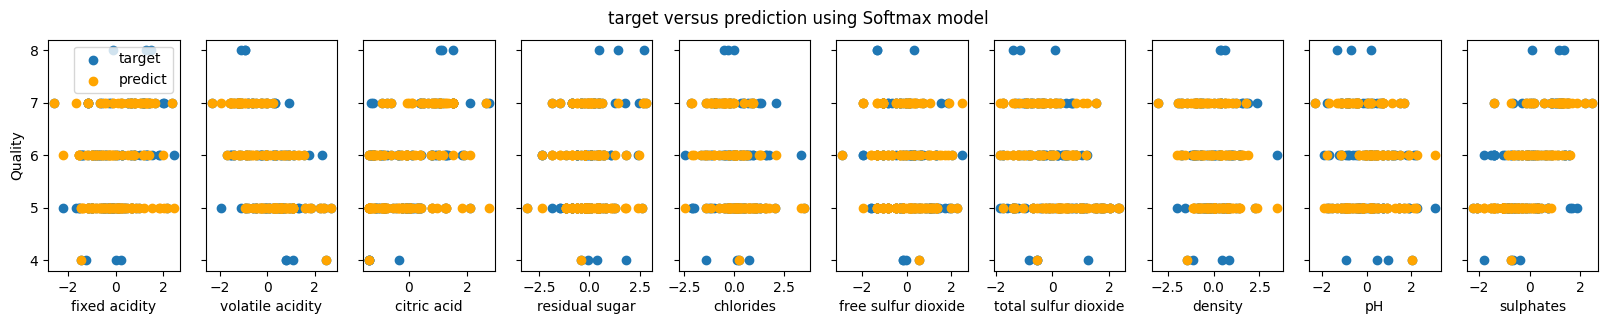

[5. 7. 5. 6. 6. 6. 7. 5. 5. 5. 5. 6. 6. 7. 5. 6. 5. 5. 5. 7. 5. 7. 6. 7.
 5. 5. 7. 7. 5. 6. 5. 5. 5. 6. 5. 6. 7. 6. 6. 7. 7. 5. 5. 6. 6. 4. 5. 5.
 5. 5. 5. 7. 5. 6. 6. 6. 6. 7. 7. 5. 7. 5. 5. 5. 7. 6. 5. 7. 5. 5. 7. 5.
 6. 7. 7. 6. 6. 6. 6. 6. 6. 5. 7. 7. 5. 5. 5. 5. 5. 6. 5. 5. 5. 5. 6. 7.
 6. 7. 5. 7. 7. 5. 5. 5. 5. 5. 5. 6. 6. 6. 5. 7. 7. 6. 5. 6. 7. 7. 6. 5.
 5. 5. 7. 5. 6. 5.]
[5 5 5 5 5 6 6 5 6 6 6 7 7 7 6 5 5 6 5 7 5 7 6 7 5 6 7 6 6 6 6 5 6 7 7 5 7
 6 7 7 6 6 5 5 6 4 5 5 5 6 6 7 6 5 5 6 6 7 7 4 7 5 5 5 7 6 5 6 5 4 7 5 6 5
 6 5 7 6 5 7 5 5 6 7 6 5 5 5 5 5 5 5 5 5 6 6 5 7 5 8 8 6 5 6 5 6 5 6 6 7 7
 6 7 5 5 6 8 7 4 5 5 5 6 5 7 6]


In [15]:
#predict target using normalized features
m = X_test.shape[0]
yp = np.zeros(m)
for loop in range(len(X_test)):
    tabProbas=np.dot(W,X_test[loop])+B
    tabProbas=sigmoid(tabProbas)
    tabProbas=tabProbas/np.sum(tabProbas)
    yp[loop]=locateMax(tabProbas)

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,nb_feature,figsize=(20, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_test[:,i]],y_test, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_test[:,i]],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
fig.suptitle("target versus prediction using Softmax model")
plt.show()
print(yp)
print(y_test)


<b><font color='black' size="5">On a aussi du mal à prédire les notes hautes et basses.
Pour avoir une autre approche que la régression ou que cette multi-classification, nous allons utiliser un réseau de Neurones. Notre réseau de neurones va utiliser Softmax pour une multi-classification avec une probabilité d'appartenance à une qualité en fonction de l'observation X, mais après plusieurs couches de transformation des données à l'aide de fonctions linéaires. </font> </b>